In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Selección de parámetros, validación y test

Muchos algoritmos tienen asociados algunos parámetros que influyen en la complejidad del modelo que pueden aprender. Recuerda cuando usamos `KNeighborsRegressor`. Si cambiamos el número de vecinos a considerar, obtenemos progresivamente predicciones más y más *suavizadas*:

<img src="figures/plot_kneigbors_regularization.png" width="100%">

En la figura anterior, podemos ver ajustes con tres valores diferentes para ``n_neighbors``. Con ``n_neighbors=2``, los datos se sobreajustan, el modelo es muy flexible y ajusta demasiado bien el ruido que hay presente en el dataset. Para ``n_neighbors=20``, el modelo no es suficientemente flexible y no puede ajustar la variación en los datos.

En la subfigura intermedia, hemos encontrado un buen punto intermedio, ``n_neighbors = 5``. Ajusta los datos bastante bien y no sufre ni de sobre-aprendizaje ni de infra-aprendizaje. Nos gustaría disponer de un método cuantitativo para identificar tanto el sobre-entrenamiento como el infra-entrenamiento y optimizar los hiperparámetros (en este caso, el número de vecinos) para llegar a los mejores resultados.

Intentamos obtener un equilibrio entre recordar particularidades (y ruido) de los datos de entrenamiento y modelar la suficiente variabilidad de los mismos. Este equilibrio necesita obtenerse para cualquier algoritmo de aprendizaje automático y es un concepto central, denominado equilibrio bias-varianza o "sobre-ajuste Vs. infra-ajuste"

<img src="figures/overfitting_underfitting_cartoon.svg" width="100%">


## Hiperparámetros, sobre-ajuste e infra-ajuste

Desafortunadamente, no hay un regla general para conseguir llegar a este punto óptimo y, por ello, el usuario debe encontrar el mejor equilibrio posible entre complejidad del modelo y generalización, probando distintas opciones para los hiper-parámetros. Los hiper-parámetros son aquellos parámetros que podemos ajustar sobre un algoritmos de aprendizaje automático (algoritmo que, a su vez, ajusta los parámetros del modelo en función de los datos de entrenamiento, de ahí el "hiper"). El número de vecinos $k$ del algoritmo kNN es un hiper-parámetro.

A menudo este ajuste de hiper-parámetros se hace mediante una búsqueda por fuerza bruta, por ejemplo usando varios valores de ``n_neighbors``:

In [2]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
# Generamos un dataset sintético:
x = np.linspace(-3, 3, 100)
rng = np.random.RandomState(42)
y = np.sin(4 * x) + x + rng.normal(size=len(x))
X = x[:, np.newaxis]

cv = KFold(shuffle=True)

# Para cada parámetro, repetimos una validación cruzada
for n_neighbors in [1, 3, 5, 10, 20]:
    scores = cross_val_score(KNeighborsRegressor(n_neighbors=n_neighbors), X, y, cv=cv)
    print("n_neighbors: %d, rendimiento medio: %f" % (n_neighbors, np.mean(scores)))

n_neighbors: 1, rendimiento medio: 0.560551
n_neighbors: 3, rendimiento medio: 0.748817
n_neighbors: 5, rendimiento medio: 0.722608
n_neighbors: 10, rendimiento medio: 0.733813
n_neighbors: 20, rendimiento medio: 0.592394


Hay una función en scikit-learn, llamada ``validation_plot``, que produce una figura similar a la que vimos previamente. Representa un parámetro, como el número de vecinos, enfrentado a los errores de entrenamiento y validación (utilizando validación cruzada):

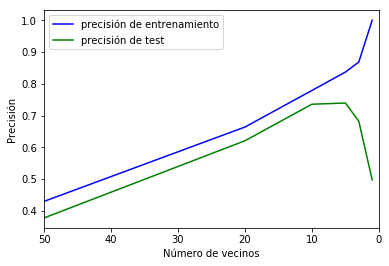

In [3]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 3, 5, 10, 20, 50]
train_scores, test_scores = validation_curve(KNeighborsRegressor(), X, y, param_name="n_neighbors",
                                             param_range=n_neighbors, cv=cv)
plt.plot(n_neighbors, train_scores.mean(axis=1), 'b', label="precisión de entrenamiento")
plt.plot(n_neighbors, test_scores.mean(axis=1), 'g', label="precisión de test")
plt.ylabel('Precisión')
plt.xlabel('Número de vecinos')
plt.xlim([50, 0])
plt.legend(loc="best");

<div class="alert alert-warning">
    Observa que muchos vecinos resultan en un modelo suavizado o más simple, por lo que el eje X se ha dibujado invertido.
</div>

Si más de un parámetro es importante, como los parámetros ``C`` y ``gamma`` de una máquina de vectores soporte (SVM) (de las cuales hablaremos después), se intentan todas las posibles combinaciones de parámetros:

In [4]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR

# Hacer validación cruzada para cada combinación de parámetros:
for C in [0.001, 0.01, 0.1, 1, 10]:
    for gamma in [0.001, 0.01, 0.1, 1]:
        scores = cross_val_score(SVR(C=C, gamma=gamma), X, y, cv=cv)
        print("C: %f, gamma: %f, valor medio de R^2: %f" % (C, gamma, np.mean(scores)))

C: 0.001000, gamma: 0.001000, valor medio de R^2: -0.045643
C: 0.001000, gamma: 0.010000, valor medio de R^2: -0.019171
C: 0.001000, gamma: 0.100000, valor medio de R^2: 0.005072
C: 0.001000, gamma: 1.000000, valor medio de R^2: 0.005677
C: 0.010000, gamma: 0.001000, valor medio de R^2: -0.062664
C: 0.010000, gamma: 0.010000, valor medio de R^2: -0.049579
C: 0.010000, gamma: 0.100000, valor medio de R^2: -0.045610
C: 0.010000, gamma: 1.000000, valor medio de R^2: 0.013984
C: 0.100000, gamma: 0.001000, valor medio de R^2: 0.007452
C: 0.100000, gamma: 0.010000, valor medio de R^2: 0.066077
C: 0.100000, gamma: 0.100000, valor medio de R^2: 0.510740
C: 0.100000, gamma: 1.000000, valor medio de R^2: 0.440770
C: 1.000000, gamma: 0.001000, valor medio de R^2: 0.193789
C: 1.000000, gamma: 0.010000, valor medio de R^2: 0.576038
C: 1.000000, gamma: 0.100000, valor medio de R^2: 0.661906
C: 1.000000, gamma: 1.000000, valor medio de R^2: 0.705559
C: 10.000000, gamma: 0.001000, valor medio de R^2: 

Como esto es algo que se hace frecuentemente en aprendizaje automático, hay una clase ya implementada en scikit-learn, ``GridSearchCV``. ``GridSearchCV`` utiliza un diccionario que describe los parámetros que deberían probarse y un modelo que entrenar.

La rejilla de parámetros se define como un diccionario, donde las claves son los parámetros y los valores son las cantidades a probar.

In [5]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv, verbose=3)

Una de las cosas interesantes de GridSearchCV es que es un *meta-estimador*. Utiliza un estimador como SVR y crea un nuevo estimador que se comporta exactamente igual que SVR, por lo que podemos llamar a ``fit`` para entrenarlo:

In [6]:
grid.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV]  C=0.001, gamma=0.001, score=-0.005683970640917525, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV]  C=0.001, gamma=0.001, score=-0.024549775721374623, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV]  C=0.001, gamma=0.001, score=-0.0007957566214809031, total=   0.0s
[CV] C=0.001, gamma=0.01 .............................................
[CV] . C=0.001, gamma=0.01, score=-0.003895294422170848, total=   0.0s
[CV] C=0.001, gamma=0.01 .............................................
[CV] .. C=0.001, gamma=0.01, score=-0.02195947664094433, total=   0.0s
[CV] C=0.001, gamma=0.01 .............................................
[CV] .. C=0.001, gamma=0.01, score=0.001360633567684455, total=   0.0s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .. C=0.001

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.1s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

``GridSearchCV`` aplica un proceso algo más complejo que el visto anteriormente. Primero, ejecuta el mismo bucle de validación cruzada para encontrar la mejor combinación de parámetros. Una vez tiene la mejor combinación, ejecuta el método ``fit`` de nuevo sobre todos los datos que se le pasan (sin validación cruzada), para construir un nuevo modelo con los parámetros óptimos obtenidos anteriormente.

Después, utilizando los métodos ``predict`` o ``score`` podemos realizar una nueva predicción:


In [7]:
grid.predict(X)

array([-1.79762875, -1.74054091, -1.71412904, -1.72272347, -1.76880247,
       -1.8527208 , -1.97255382, -2.12407501, -2.30087676, -2.49463429,
       -2.695503  , -2.89262935, -3.07474705, -3.23082299, -3.35071314,
       -3.42578612, -3.44947391, -3.41771237, -3.32924127, -3.18574205,
       -2.9918017 , -2.75470244, -2.48404785, -2.19124658, -1.88888388,
       -1.59001819, -1.30744475, -1.05297034, -0.8367425 , -0.66667333,
       -0.54799235, -0.4829551 , -0.4707249 , -0.50743515, -0.58642852,
       -0.69865919, -0.83323456, -0.97806438, -1.12057877, -1.24847261,
       -1.35043139, -1.41679516, -1.44012026, -1.41560488, -1.3413525 ,
       -1.21845724, -1.05090633, -0.84530623, -0.61045003, -0.35675398,
       -0.09559933,  0.16137852,  0.40300817,  0.61926205,  0.80185531,
        0.94472644,  1.04437082,  1.10000798,  1.11357463,  1.08954695,
        1.03460678,  0.95717608,  0.86685224,  0.7737823 ,  0.68801751,
        0.61888941,  0.57444669,  0.56098656,  0.58270777,  0.64

Puedes observar los mejores parámetros obtenidos por ``GridSearchCV`` en su atributo ``best_params_`` y la puntuación correspondiente en su atributo ``best_score_``:

In [8]:
print(grid.best_score_)

0.7283676018376015


In [9]:
print(grid.best_params_)

{'C': 10, 'gamma': 1}


Pero puedes investigar más a fondo el rendimiento y algunas cosas más sobre cada una de las combinaciones de parámetros accediendo al atributo `cv_results_`. `cv_results_` es un diccionario donde cada clave es una cadena y cada valor un array. Se puede por tanto usar para crear un ``DataFrame`` de pandas.

In [10]:
type(grid.cv_results_)

sklearn.utils.deprecation.DeprecationDict

In [11]:
print(grid.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])


In [12]:
import pandas as pd

cv_results = pd.DataFrame(grid.cv_results_)
cv_results.head()

/Users/zuluagasd/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/zuluagasd/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/zuluagasd/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, *

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.000604,0.000171,0.000340,0.000054,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",-0.005684,-0.024550,-0.000796,-0.010297,0.010201,20,-0.000024,-0.015002,-0.004363,-0.006463,0.006292
1,0.000610,0.000072,0.000427,0.000070,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",-0.003895,-0.021959,0.001361,-0.008122,0.009947,19,0.002060,-0.012508,-0.002577,-0.004342,0.006077
2,0.000437,0.000056,0.000423,0.000129,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.003809,-0.010672,0.010746,0.001319,0.008881,16,0.010594,-0.001918,0.005647,0.004774,0.005145
3,0.000568,0.000088,0.000400,0.000054,0.001,1,"{'C': 0.001, 'gamma': 1}",0.002724,-0.012268,0.008977,-0.000160,0.008874,17,0.009180,-0.003715,0.005122,0.003529,0.005383
4,0.000403,0.000030,0.000301,0.000038,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",-0.003719,-0.021693,0.001587,-0.007900,0.009921,18,0.002282,-0.012243,-0.002415,-0.004125,0.006052


In [13]:
cv_results_tiny = cv_results[['param_C', 'param_gamma', 'mean_test_score']]
cv_results_tiny.sort_values(by='mean_test_score', ascending=False).head()

,param_C,param_gamma,mean_test_score
19,10,1,0.728368
15,1,1,0.701530
14,1,0.1,0.655335
18,10,0.1,0.648984
17,10,0.01,0.602654


Sin embargo, hay un problema en la utilización de este rendimiento para la evaluación. Puedes estar incurriendo en lo que se denomina un error de probar varias hipótesis. Si tienes muchas combinaciones de parámetros, algunas de ellas puede ser que funcionen mejor solo por aleatoriedad y que el rendimiento que estás obteniendo no sea el mismo cuando tengamos nuevos datos. Por tanto, es en general buena idea realizar una separación en entrenamiento y test previa a la búsqueda *grid*. Este patrón se suele denominar partición de entrenamiento, test y validación, y es bastante común en aprendizaje automático:

<img src="figures/grid_search_cross_validation.svg" width="100%">

Podemos emular este proceso fácilmente dividiendo primero los datos con ``train_test_split``, aplicando ``GridSearchCV`` al conjunto de entrenamiento, y calculando el ``score`` correspondiente solo con el conjunto de test:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
cv = KFold(n_splits=10, shuffle=True)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

Podemos comprobar de nuevo los parámetros obtenidos con:

In [ ]:
grid.best_params_

A veces se utiliza un esquema más simple, que parte los datos en tres subconjuntos entrenamiento, validación y test. Esto es una alternativa si tu conjunto de datos es muy grande o si es imposible entrenar muchos modelos mediante validación cruzada, porque entrenar cada modelo es muy costoso computacionalmente. Para hacer este tipo de partición tendríamos que hacer una partición con ``train_test_split`` y después aplicar ``GridSearchCV`` con un ``ShuffleSplit`` y una sola iteración:

<img src="figures/train_validation_test2.svg" width="100%">

In [ ]:
from sklearn.model_selection import train_test_split, ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
single_split_cv = ShuffleSplit(n_splits=1)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=single_split_cv, verbose=3)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

Esto es mucho más rápido pero puede resultar en valores peores de los hiper-parámetros y, por tanto, peores resultados.

In [ ]:
clf = GridSearchCV(SVR(), param_grid=param_grid)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
      Aplica una búsqueda *grid* para encontrar el mejor valor del parámetro número de vecinos para el ``KNeighborsClassifier`` para el dataset de ``digits``.
      </li>
    </ul>
</div>